In [ ]:
%matplotlib inline
%autoreload 2

UsageError: Line magic function `%autoreload` not found.


# BCE classifier

Test of BCE baseline model and benchmarks. Reproduces mean paper results within 5%.

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
from pytorch_inferno.model_wrapper import ModelWrapper
from pytorch_inferno.callback import *
from pytorch_inferno.data import get_paper_data
from pytorch_inferno.plotting import *
from pytorch_inferno.inference import *
from pytorch_inferno.utils import *

from fastcore.all import partialler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from typing import *
from collections import OrderedDict

import torch.nn as nn
from torch import optim
import torch
from torch import Tensor
from torch import autograd

In [ ]:
net = nn.Sequential(nn.Linear(3,100),  nn.ReLU(),
                    nn.Linear(100,100),nn.ReLU(),
                    nn.Linear(100,1),  nn.Sigmoid())
init_net(net)

In [ ]:
model = ModelWrapper(net)
data, test = get_paper_data(200000, bs=64, n_test=1000000)

In [ ]:
model.fit(200, data=data, opt=partialler(optim.SGD,lr=1e-3), loss=nn.BCELoss(),
          cbs=[LossTracker(),SaveBest('weights/best_bce.h5'),EarlyStopping(10)])

1: Train=0.4401596694660187 Valid=0.40934421967506407
2: Train=0.3955455165576935 Valid=0.3814330395126343
3: Train=0.3735753394079208 Valid=0.3641806226539612
4: Train=0.35999459485530855 Valid=0.35342187165260314
5: Train=0.3515187005662918 Valid=0.34703761987686155
6: Train=0.34629804510593415 Valid=0.34279413098335265
7: Train=0.34318549807071685 Valid=0.3406400420475006
8: Train=0.34128225273609164 Valid=0.33914463949203494
9: Train=0.34018883963108065 Valid=0.3380114377498627
10: Train=0.33946443359851836 Valid=0.3372597011375427
11: Train=0.3389732162570953 Valid=0.3373694033241272
12: Train=0.3386864182853699 Valid=0.3370241341876984
13: Train=0.33839162315368654 Valid=0.33655655870437623
14: Train=0.3382486596488953 Valid=0.33666536286354065
15: Train=0.3380545433139801 Valid=0.33611120774269104
16: Train=0.33789991596221924 Valid=0.33597198868751527
17: Train=0.3378156385612488 Valid=0.3359025964164734
18: Train=0.3376615642356873 Valid=0.3358702029132843
19: Train=0.33752401

151: Train=0.33326829611301423 Valid=0.3320400103664398
152: Train=0.3332729207134247 Valid=0.33225296505928037
153: Train=0.33332246705532076 Valid=0.3321785771656036
154: Train=0.3333142163801193 Valid=0.3321405253219604
155: Train=0.33329975813388824 Valid=0.3321521426105499
156: Train=0.3333130160713196 Valid=0.3323877345466614
157: Train=0.3332772430896759 Valid=0.3324062751865387
158: Train=0.33325417152404785 Valid=0.3321454641199112
159: Train=0.33330262325286864 Valid=0.33203717700004576
160: Train=0.33329062415122984 Valid=0.33198393109321594
161: Train=0.3332824336576462 Valid=0.3319967373466492
162: Train=0.33327312892198563 Valid=0.3320194143295288
163: Train=0.33326279490947724 Valid=0.3327838553237915
164: Train=0.33326371988773346 Valid=0.3321148463916779
165: Train=0.3332704231548309 Valid=0.33202244709968565
166: Train=0.3331906876707077 Valid=0.332341728143692
167: Train=0.3332507816505432 Valid=0.33220772681236266
168: Train=0.3332554066896439 Valid=0.33210696759223

In [ ]:
model.save('weights/BCE_Test.h5')

In [ ]:
model.load('weights/BCE_Test.h5')

## BM 0

In [ ]:
preds = model._predict_dl(test)

In [ ]:
preds

array([[8.0165595e-01],
       [8.6571717e-01],
       [9.2349386e-01],
       ...,
       [1.0477606e-02],
       [8.6404339e-10],
       [1.5087092e-04]], dtype=float32)

In [ ]:
df = pd.DataFrame({'pred':preds.squeeze()})
df['gen_target'] = test.dataset.y
df.head()

,pred,gen_target
0,0.801656,1.0
1,0.865717,1.0
2,0.923494,1.0
3,0.671968,1.0
4,0.744155,1.0


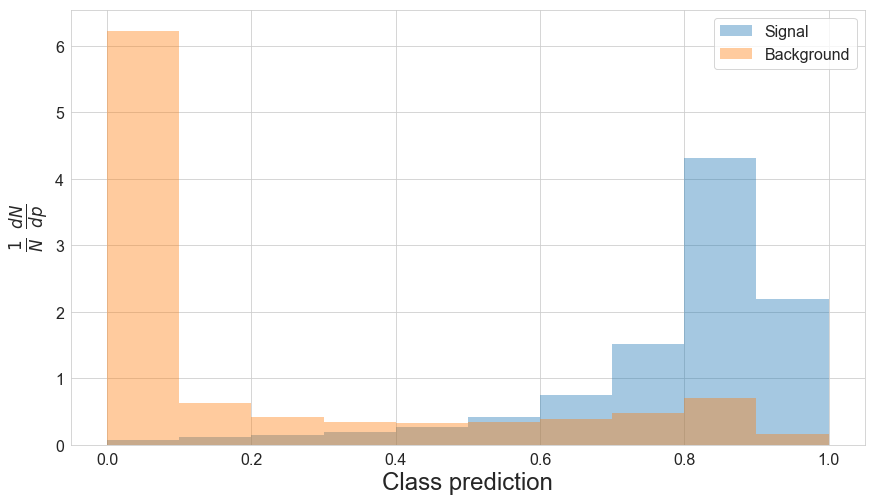

In [ ]:
plot_preds(df)

In [ ]:
bin_preds(df, np.linspace(0,1,11))

In [ ]:
df.head()

,pred,gen_target,pred_bin
0,0.801656,1.0,8
1,0.865717,1.0,8
2,0.923494,1.0,9
3,0.671968,1.0,6
4,0.744155,1.0,7


In [ ]:
f_s,f_b = get_shape(df,1),get_shape(df,0)

In [ ]:
f_s.sum(), f_b.sum()

(tensor(1.), tensor(1.))

In [ ]:
f_s, f_b

(tensor([1.9062e-02, 1.4626e-02, 1.9892e-02, 2.7224e-02, 4.2362e-02, 7.4388e-02,
         1.5124e-01, 4.3148e-01, 2.1972e-01, 2.0000e-13]),
 tensor([6.8545e-01, 4.1566e-02, 3.3612e-02, 3.2188e-02, 3.3780e-02, 3.8238e-02,
         4.8478e-02, 7.0762e-02, 1.5930e-02, 2.0000e-13]))

In [ ]:
asimov = (50*f_s)+(1000*f_b)

In [ ]:
asimov, asimov.sum()

(tensor([6.8640e+02, 4.2297e+01, 3.4607e+01, 3.3549e+01, 3.5898e+01, 4.1957e+01,
         5.6040e+01, 9.2336e+01, 2.6916e+01, 2.1000e-10]), tensor(1050.0001))

In [ ]:
n = 1050
x = np.linspace(20,80,61)
y = np.zeros_like(x)
for i,m in enumerate(x):
    pois = torch.distributions.Poisson((m*f_s)+(1000*f_b))
    y[i] = -pois.log_prob(asimov).sum()
y

array([28.80239105, 28.64399338, 28.49192047, 28.34626007, 28.20688248,
       28.07373047, 27.94677353, 27.82578278, 27.7106781 , 27.60105133,
       27.49765015, 27.40018082, 27.3086319 , 27.22160339, 27.14057922,
       27.06494141, 26.99470139, 26.92969513, 26.8698349 , 26.81515503,
       26.76552582, 26.72088242, 26.6812439 , 26.64642334, 26.61598969,
       26.59073639, 26.57075882, 26.55511475, 26.54383087, 26.53668976,
       26.53440094, 26.53710556, 26.5437088 , 26.55413437, 26.56935883,
       26.58885193, 26.61252975, 26.64057922, 26.67250443, 26.70848083,
       26.74847412, 26.79243851, 26.84038544, 26.89217758, 26.94785309,
       27.00725555, 27.07049942, 27.13751984, 27.2081337 , 27.28247833,
       27.36038208, 27.44195175, 27.52703857, 27.61588287, 27.70795441,
       27.80355072, 27.90247726, 28.00482941, 28.11048508, 28.2195282 ,
       28.33182526])

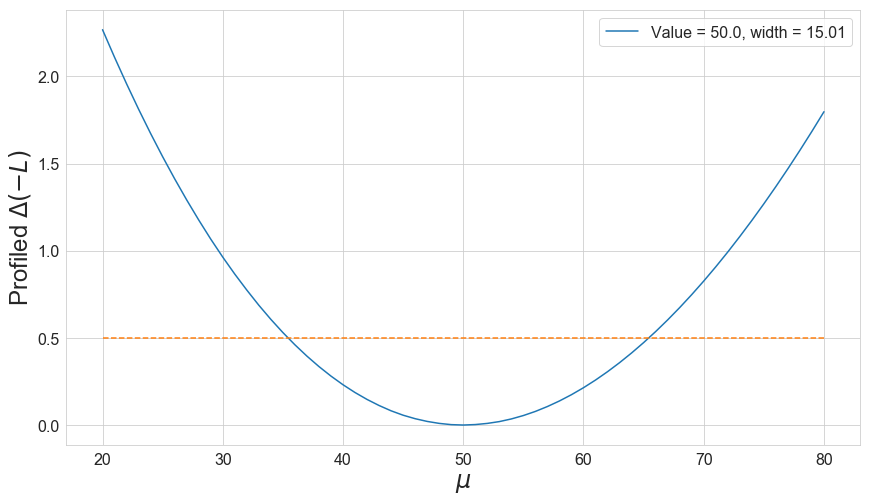

In [ ]:
plot_likelihood(y-y.min())

# Nuisances - via interpolation

In [ ]:
bkg = test.dataset.x[test.dataset.y.squeeze() == 0]
assert len(bkg) == 500000

In [ ]:
b_shapes = get_paper_syst_shapes(bkg, df, model=model, bins=np.linspace(0,1,11))

Running: r=-0.2


Running: r=0


Running: r=0.2


Running: l=2.5


Running: l=3


Running: l=3.5


In [ ]:
df

,pred,gen_target,pred_bin,pred_-0.2_3,pred_-0.2_3_bin,pred_0_3,pred_0_3_bin,pred_0.2_3,pred_0.2_3_bin,pred_0_2.5,pred_0_2.5_bin,pred_0_3.5,pred_0_3.5_bin
0,8.016559e-01,1.0,8,8.016559e-01,8,8.016559e-01,8,8.016559e-01,8,8.016559e-01,8,8.016559e-01,8
1,8.657172e-01,1.0,8,8.657172e-01,8,8.657172e-01,8,8.657172e-01,8,8.657172e-01,8,8.657172e-01,8
2,9.234939e-01,1.0,9,9.234939e-01,9,9.234939e-01,9,9.234939e-01,9,9.234939e-01,9,9.234939e-01,9
3,6.719683e-01,1.0,6,6.719683e-01,6,6.719683e-01,6,6.719683e-01,6,6.719683e-01,6,6.719683e-01,6
4,7.441548e-01,1.0,7,7.441548e-01,7,7.441548e-01,7,7.441548e-01,7,7.441548e-01,7,7.441548e-01,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
999995,1.324046e-02,0.0,0,1.826522e-02,0,1.324046e-02,0,9.508059e-03,0,1.285214e-02,0,1.364323e-02,0
999996,1.458118e-02,0.0,0,2.519483e-02,0,1.458118e-02,0,8.433408e-03,0,1.453730e-02,0,1.462518e-02,0
999997,1.047761e-02,0.0,0,1.377524e-02,0,1.047761e-02,0,8.407601e-03,0,1.015880e-02,0,1.098705e-02,0
999998,8.640434e-10,0.0,0,1.166612e-09,0,8.640434e-10,0,6.222782e-10,0,8.394827e-10,0,8.893244e-10,0


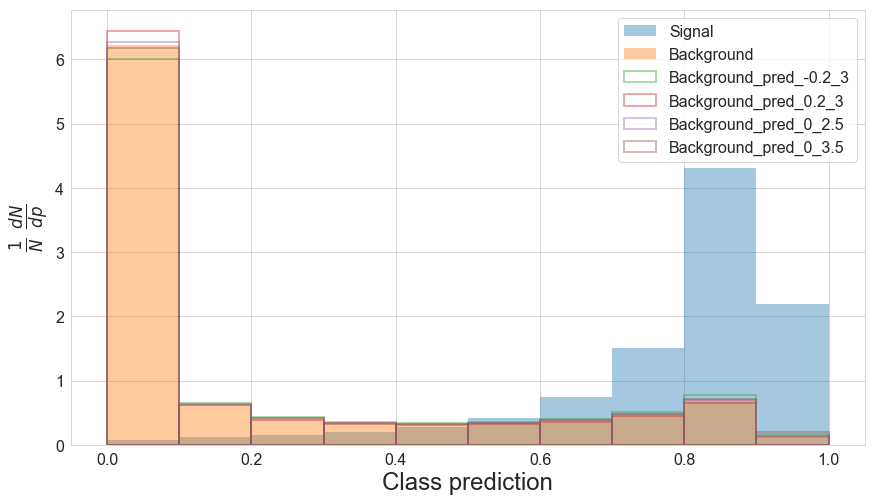

In [ ]:
plot_preds(df, pred_names=['pred', 'pred_-0.2_3', 'pred_0.2_3', 'pred_0_2.5', 'pred_0_3.5'])

In [ ]:
b_shapes['f_b_nom']

tensor([6.8545e-01, 4.1566e-02, 3.3612e-02, 3.2188e-02, 3.3780e-02, 3.8238e-02,
        4.8478e-02, 7.0762e-02, 1.5930e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[7.0629e-01, 3.9078e-02, 3.2562e-02, 3.0356e-02, 3.1714e-02, 3.6052e-02,
         4.4992e-02, 6.4510e-02, 1.4448e-02, 2.0000e-13],
        [6.8097e-01, 4.1850e-02, 3.3580e-02, 3.1860e-02, 3.3854e-02, 3.8512e-02,
         4.7950e-02, 7.0750e-02, 2.0674e-02, 2.0000e-13]])

In [ ]:
b_shapes['f_b_dw']

tensor([[6.6513e-01, 4.3118e-02, 3.5504e-02, 3.3608e-02, 3.5666e-02, 4.0938e-02,
         5.1314e-02, 7.7204e-02, 1.7518e-02, 2.0000e-13],
        [6.8992e-01, 4.1372e-02, 3.3622e-02, 3.2230e-02, 3.3860e-02, 3.8380e-02,
         4.8590e-02, 7.0456e-02, 1.1566e-02, 2.0000e-13]])

In [ ]:
f_s

tensor([1.9062e-02, 1.4626e-02, 1.9892e-02, 2.7224e-02, 4.2362e-02, 7.4388e-02,
        1.5124e-01, 4.3148e-01, 2.1972e-01, 2.0000e-13])

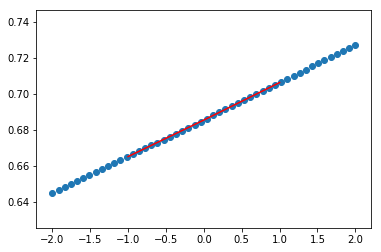

In [ ]:
i = 0
d = b_shapes['f_b_dw'][0][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][0][i]
interp = []
rs = np.linspace(-2,2)
for r in rs: interp.append(interp_shape(Tensor((r,0))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(rs, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

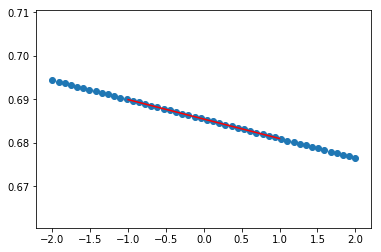

In [ ]:
i = 0
d = b_shapes['f_b_dw'][1][i]
n = b_shapes['f_b_nom'][i]
u = b_shapes['f_b_up'][1][i]
interp = []
ls = np.linspace(-2,2)
for l in ls: interp.append(interp_shape(Tensor((0,l))[None,:], **b_shapes)[0][i].data.item())
plt.scatter(ls, interp)
plt.plot([-1,0,1],[d,n,u], label=i, color='r')

In [ ]:
b_shapes['f_b_nom']

tensor([6.8545e-01, 4.1566e-02, 3.3612e-02, 3.2188e-02, 3.3780e-02, 3.8238e-02,
        4.8478e-02, 7.0762e-02, 1.5930e-02, 2.0000e-13])

In [ ]:
alpha = Tensor((1,0))[None,:]
interp_shape(alpha, **b_shapes).squeeze()

tensor([7.0629e-01, 3.9078e-02, 3.2562e-02, 3.0356e-02, 3.1714e-02, 3.6052e-02,
        4.4992e-02, 6.4510e-02, 1.4448e-02, 2.0000e-13])

In [ ]:
b_shapes['f_b_up']

tensor([[7.0629e-01, 3.9078e-02, 3.2562e-02, 3.0356e-02, 3.1714e-02, 3.6052e-02,
         4.4992e-02, 6.4510e-02, 1.4448e-02, 2.0000e-13],
        [6.8097e-01, 4.1850e-02, 3.3580e-02, 3.1860e-02, 3.3854e-02, 3.8512e-02,
         4.7950e-02, 7.0750e-02, 2.0674e-02, 2.0000e-13]])

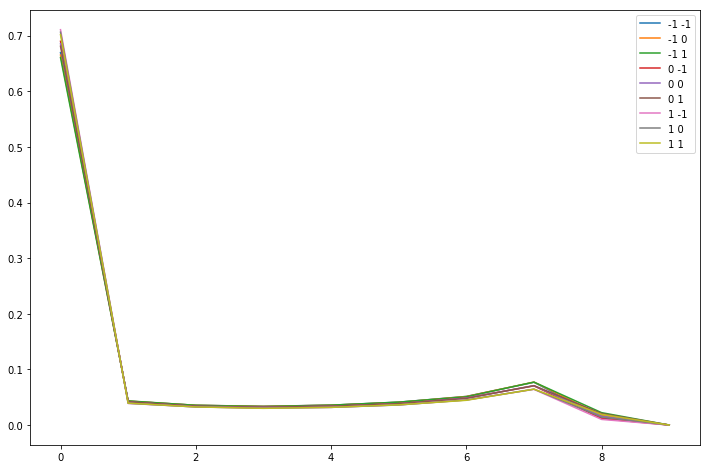

In [ ]:
fig = plt.figure(figsize=(12,8))
for r in [-1,0,1]:
    for l in [-1,0,1]:
        alpha = Tensor((r,l))[None,:]
        s = interp_shape(alpha, **b_shapes).squeeze()
        plt.plot(s, label=f'{r} {l}')
plt.legend()

# Newton

In [ ]:
profiler = partialler(calc_profile, n=1050, mu_scan=torch.linspace(20,80,61), true_mu=50)

## BM 1
r free, l fixed

In [ ]:
bm1_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                            ('f_b_up',  b_shapes['f_b_up'][0][None,:]),
                            ('f_b_dw',  b_shapes['f_b_dw'][0][None,:])])

In [ ]:
bm1_b_shapes['f_b_up'].shape

torch.Size([1, 10])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1_b_shapes)

Linear regime: Mu 20.0, alpha tensor([-1.0556])
Linear regime: Mu 21.0, alpha tensor([-1.0188])


In [ ]:
nll = to_np(nll)

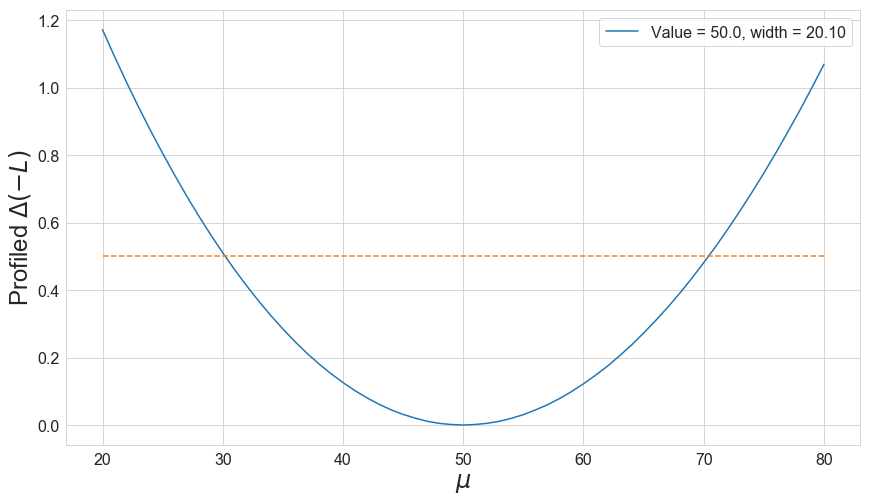

In [ ]:
plot_likelihood(nll-nll.min())

## BM 1l
r fixed, l free

In [ ]:
bm1l_b_shapes = OrderedDict([('f_b_nom', b_shapes['f_b_nom']),
                             ('f_b_up',  b_shapes['f_b_up'][1][None,:]),
                             ('f_b_dw',  b_shapes['f_b_dw'][1][None,:])])

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **bm1l_b_shapes)

Linear regime: Mu 20.0, alpha tensor([1.2783])
Linear regime: Mu 21.0, alpha tensor([1.2358])
Linear regime: Mu 22.0, alpha tensor([1.1933])
Linear regime: Mu 23.0, alpha tensor([1.1509])
Linear regime: Mu 24.0, alpha tensor([1.1084])
Linear regime: Mu 25.0, alpha tensor([1.0658])
Linear regime: Mu 70.0, alpha tensor([-1.0000])
Linear regime: Mu 71.0, alpha tensor([-1.0286])
Linear regime: Mu 72.0, alpha tensor([-1.0775])
Linear regime: Mu 73.0, alpha tensor([-1.1264])
Linear regime: Mu 74.0, alpha tensor([-1.1752])
Linear regime: Mu 75.0, alpha tensor([-1.2241])
Linear regime: Mu 76.0, alpha tensor([-1.2729])
Linear regime: Mu 77.0, alpha tensor([-1.3218])
Linear regime: Mu 78.0, alpha tensor([-1.3706])
Linear regime: Mu 79.0, alpha tensor([-1.4194])
Linear regime: Mu 80.0, alpha tensor([-1.4682])


In [ ]:
nll = to_np(nll)

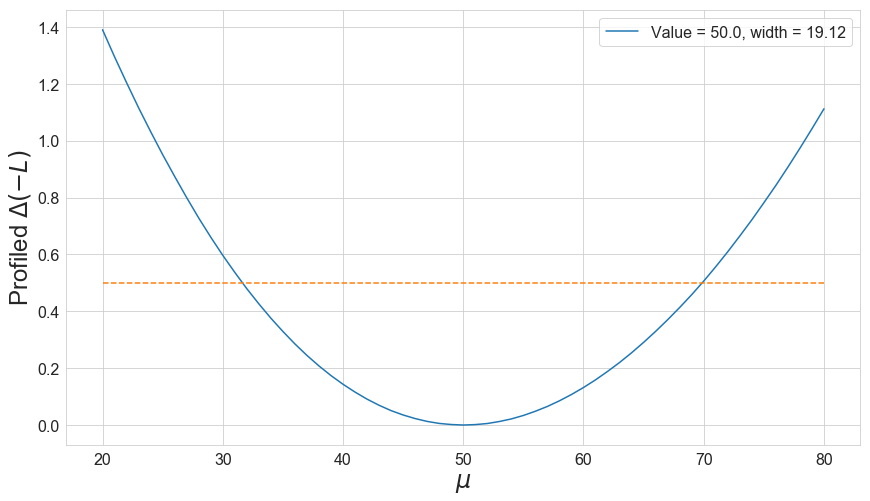

In [ ]:
plot_likelihood(nll-nll.min())

## BM 2

In [ ]:
nll = profiler(f_s=f_s, n_steps=100, **b_shapes)

Linear regime: Mu 77.0, alpha tensor([ 0.6371, -1.0006])
Linear regime: Mu 78.0, alpha tensor([ 0.6617, -1.0250])
Linear regime: Mu 79.0, alpha tensor([ 0.6835, -1.0626])
Linear regime: Mu 80.0, alpha tensor([ 0.7052, -1.1003])


In [ ]:
nll = to_np(nll)

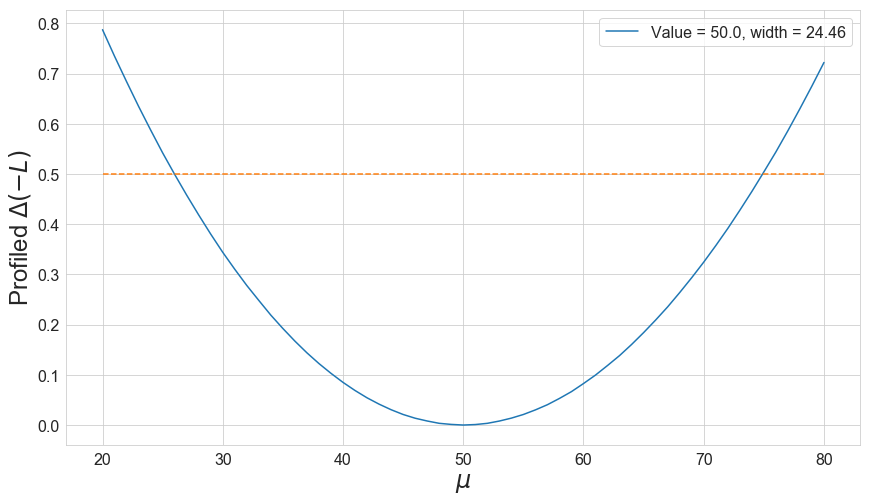

In [ ]:
plot_likelihood(nll-nll.min())